In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
random_state = 23

## function

In [3]:
def nanfill(data,row, column):
    tag = data.iloc[row,1]
    # print(data[data.iloc[:,1] == tag].iloc[:,column],'\n')
    temp = data[data.iloc[:,1] == tag].iloc[:,column]
    temp = np.average(temp[temp.notna()])
    if (pd.isna(temp)):
        print(row,column)
    data.iloc[row,column] = temp

def normalization(data):
    for i in range(data.shape[1]):
        avg = data.iloc[:,i].mean()
        std = data.iloc[:,i].std(ddof = 1)
        data.iloc[:,i] = (data.iloc[:,i] - avg) / std


# 计算交叉验证结果的均值和标准差， 默认为五折交叉验证，结果为相关系数R2      
def cross_validate(models, cv = 5, scoring = 'r2'):
    means = []
    stds = []
    best_score = 0
    best_index = 0
    
    for index, model in enumerate(models):
        score = cross_val_score(model, X_train, y_train, cv = cv, scoring = scoring)
        means.append(score.mean())
        stds.append(score.std(ddof = 1))
        
        # get the best alpha and score
        curr_score = score.mean()
        if curr_score > best_score:
            best_score = curr_score
            best_index = index
    return means, stds, best_index

## compare

In [4]:
def MAE(name, model, Xtrain, Xtest, ytrain, ytest):
    ypred = model.predict(Xtrain)
    mae_train = mean_absolute_error(ytrain, ypred)
    ypred = model.predict(Xtest)
    mae_test = mean_absolute_error(ytest, ypred)
    print("MAE    Train:%f      Test:%f"%(mae_train, mae_test))
    #print("The MAE for the %s model with the training data was %f and with the test data was %f"%(name, mae_train, mae_test))

def MSE(name, model, Xtrain, Xtest, ytrain, ytest):
    ypred = model.predict(Xtrain)
    mse_train = mean_squared_error(ytrain, ypred, squared=True)
    ypred = model.predict(Xtest)
    mse_test = mean_squared_error(ytest, ypred, squared=True)
    print("MSE    Train:%f      Test:%f" % (mse_train, mse_test))
    #print("The RMSE for the %s model with the training data was %f and with the test data was %f" % (name, mse_train, mse_test))

def r_sq(name, model, Xtrain, Xtest, ytrain, ytest):
    ypred = model.predict(Xtrain)
    rsq_train = r2_score(ytrain, ypred)
    ypred = model.predict(Xtest)
    rsq_test = r2_score(ytest, ypred)
    print("RSQ    Train:%f      Test:%f" % (rsq_train, rsq_test))
    #print("The R squared score for the %s model with the training data was %f and with the test data was %f" % (name, rsq_train, rsq_test))

def plot(name, model, Xtrain, Xtest, ytrain, ytest, filename):
    ypred = model.predict(Xtrain)
    fig, axs = plt.subplots()
    axs.scatter(Xtrain[:,1], ytrain, s=20, c='b', marker='+')
    axs.scatter(Xtrain[:,1], ypred, s=20, c='r', marker='+')
    axs.set_title(name + ' - Precicted Training Data')
    axs.set_xlabel('feature')
    axs.set_ylabel('amount')
    axs.legend(['Target', 'Predictions'])
    fig.show()
    #fig.savefig('Plots/Prediction Plots/' + filename + '_train_pred')

    ypred = model.predict(Xtest)
    fig, axs = plt.subplots()
    axs.scatter(Xtest[:, 1], ytest, s=20, c='b', marker='+')
    axs.scatter(Xtest[:, 1], ypred, s=20, c='r', marker='+')
    axs.set_title(name + ' - Predicted Test Data')
    axs.set_xlabel('feature')
    axs.set_ylabel('amount')
    axs.legend(['Target', 'Predictions'])
    fig.show()
    
def plot_model_res(model, name):
    strategy = "mean"
    print("{}:".format(name))
    MAE("{}".format(name), model, X_train, X_test, y_train, y_test)
    MSE("{}".format(name), model, X_train, X_test, y_train, y_test)
    r_sq("{}".format(name), model, X_train, X_test, y_train, y_test)
    plot("{} Regression".format(name), model, X_train, X_test, y_train, y_test, "d")

## Data import

In [5]:
raw_data = pd.read_csv('Data.csv')

for i in range(3):
    for j in range(raw_data.shape[0]):
        raw_data.iloc[j,i+2] = np.float64(raw_data.iloc[j,i+2].replace(',',''))
        
for i in range(raw_data.shape[0]):
    for j in range(raw_data.shape[1]):
        if (pd.isna(raw_data.iloc[i,j])):
            nanfill(raw_data,i,j)

## Analysis of Correlation

In [6]:
group = [['LACCESS_POP15','LACCESS_LOWI15','LACCESS_HHNV15','LACCESS_CHILD15','LACCESS_SENIORS15'],
        ['GROCPTH16', 'SUPERCPTH16', 'CONVSPTH16', 'SPECSPTH16', 'WICSPTH16'],
        ['FFRPTH16', 'FSRPTH16'],
        ['FOODINSEC_15_17', 'VLFOODSEC_15_17'],
        ['FMRKT_WIC18', 'FMRKT_WICCASH18'],
        ['POVRATE15', 'CHILDPOVRATE15']]

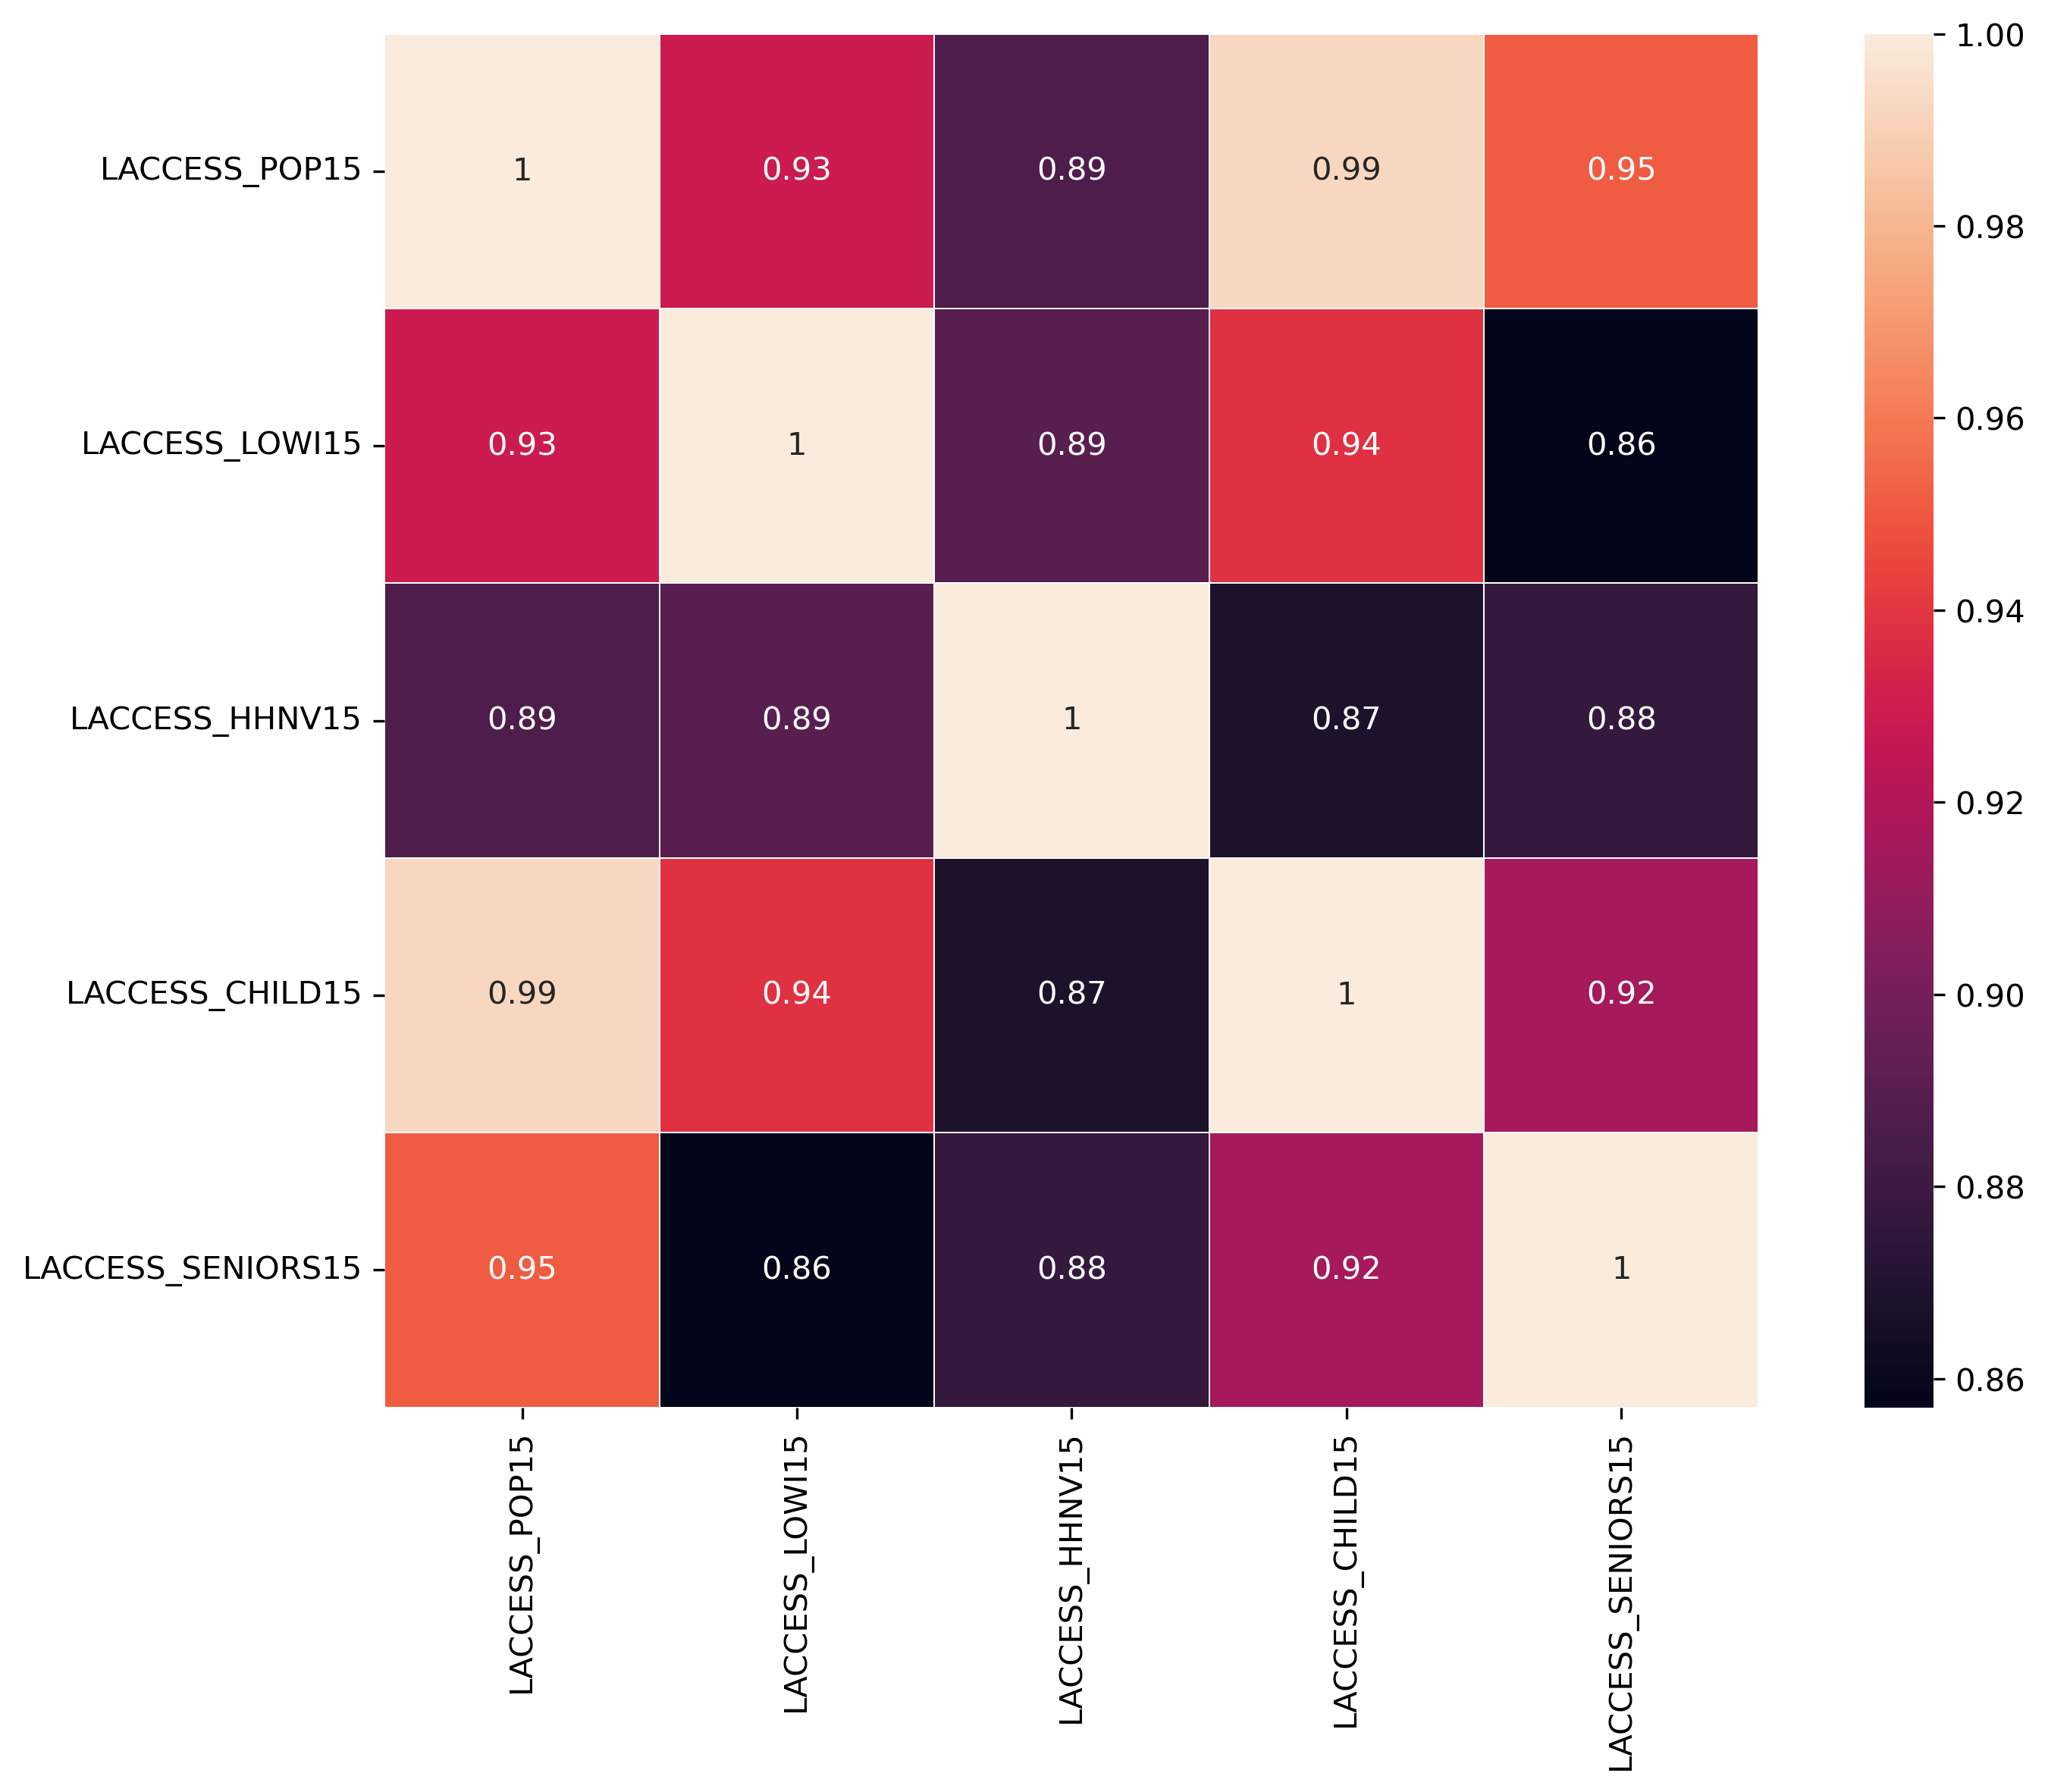

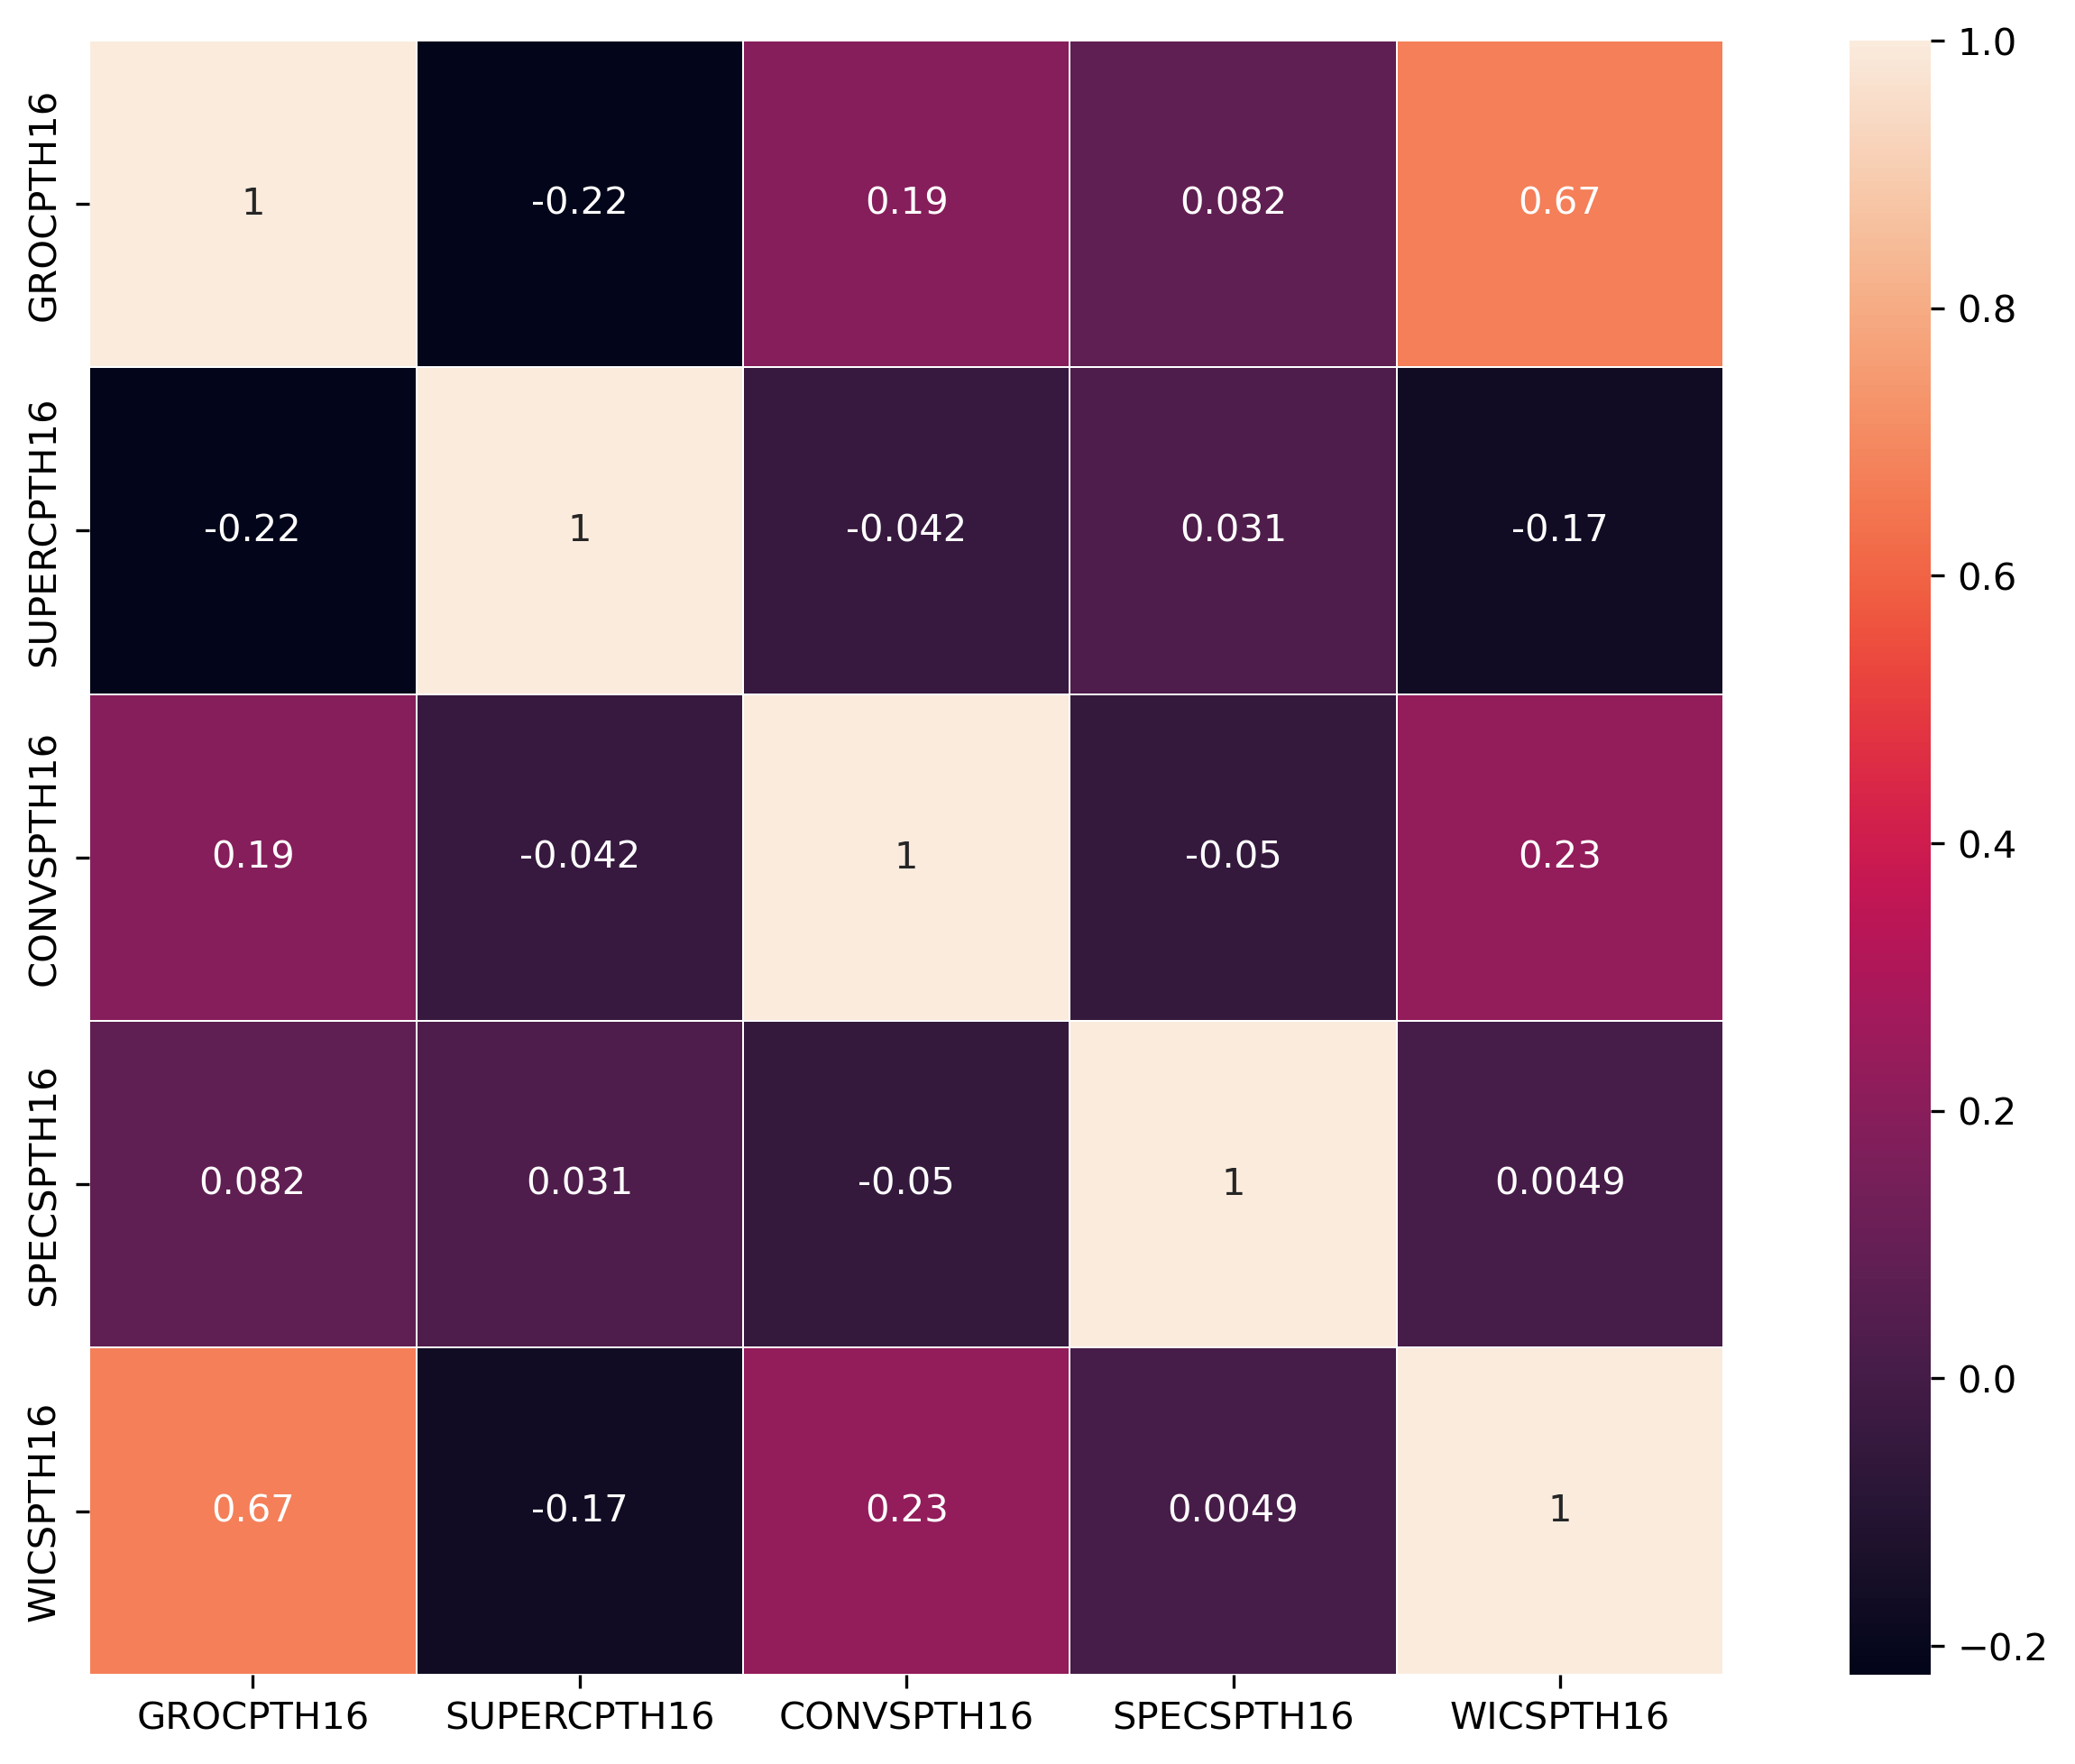

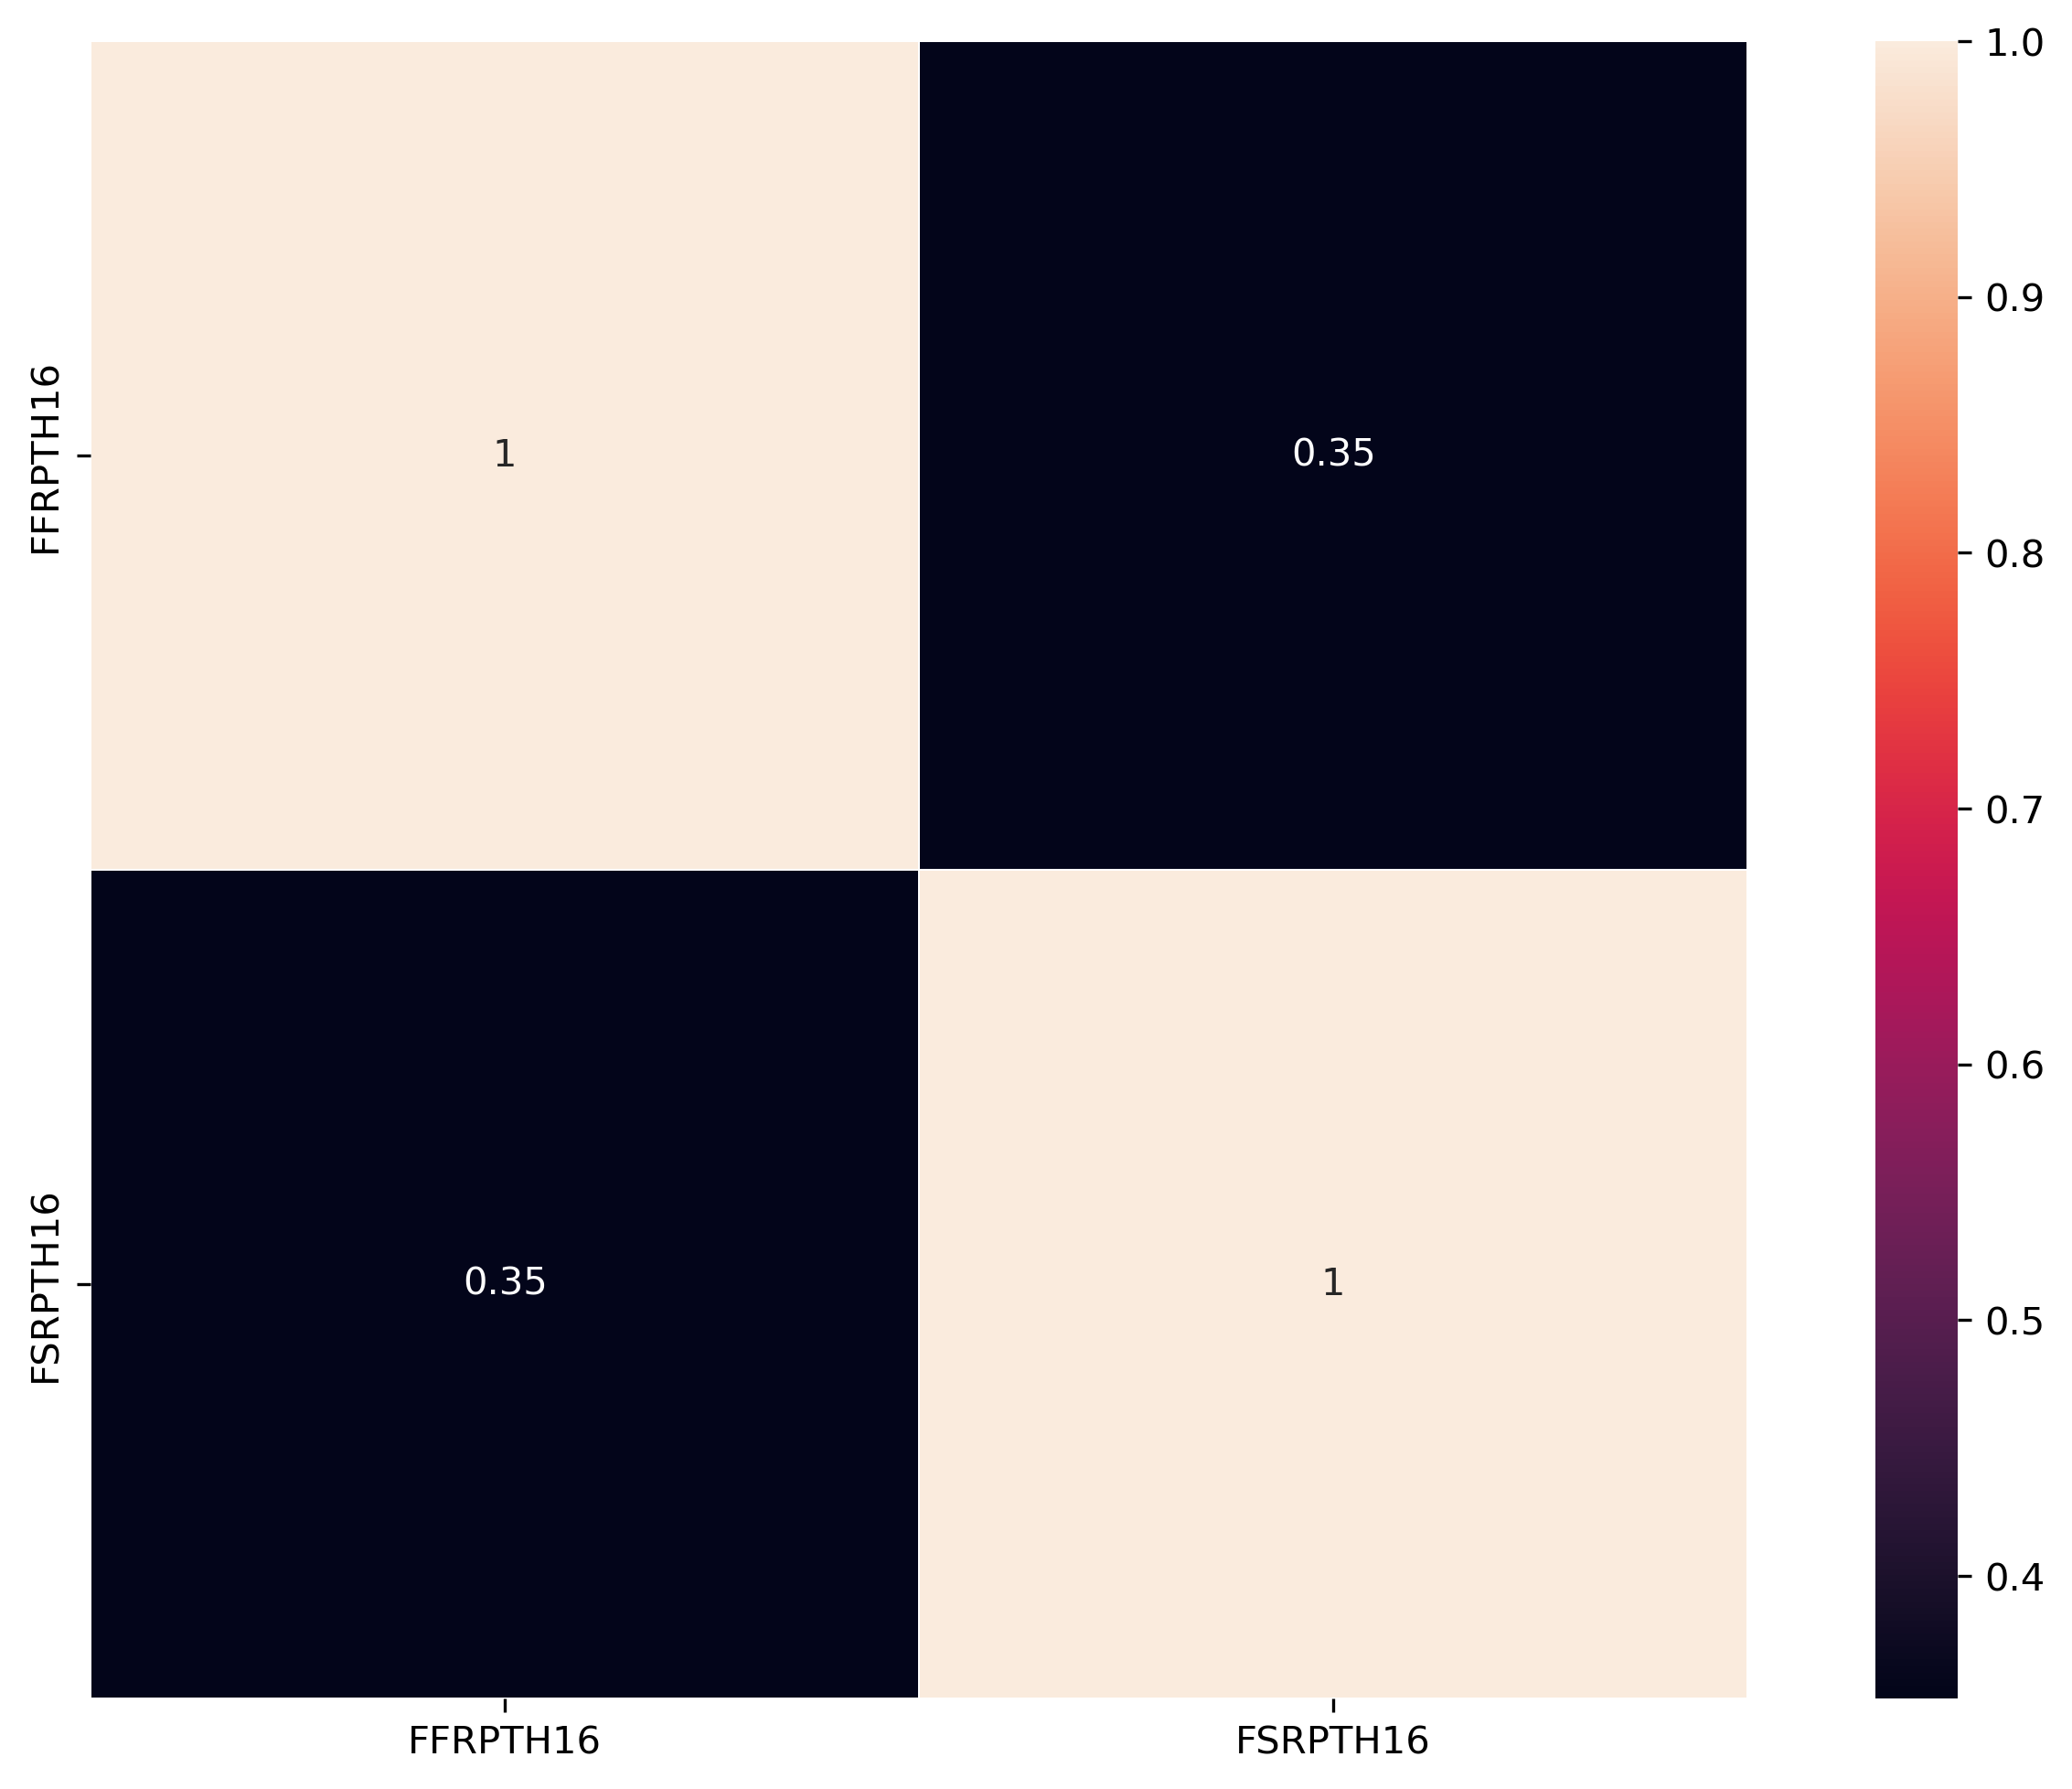

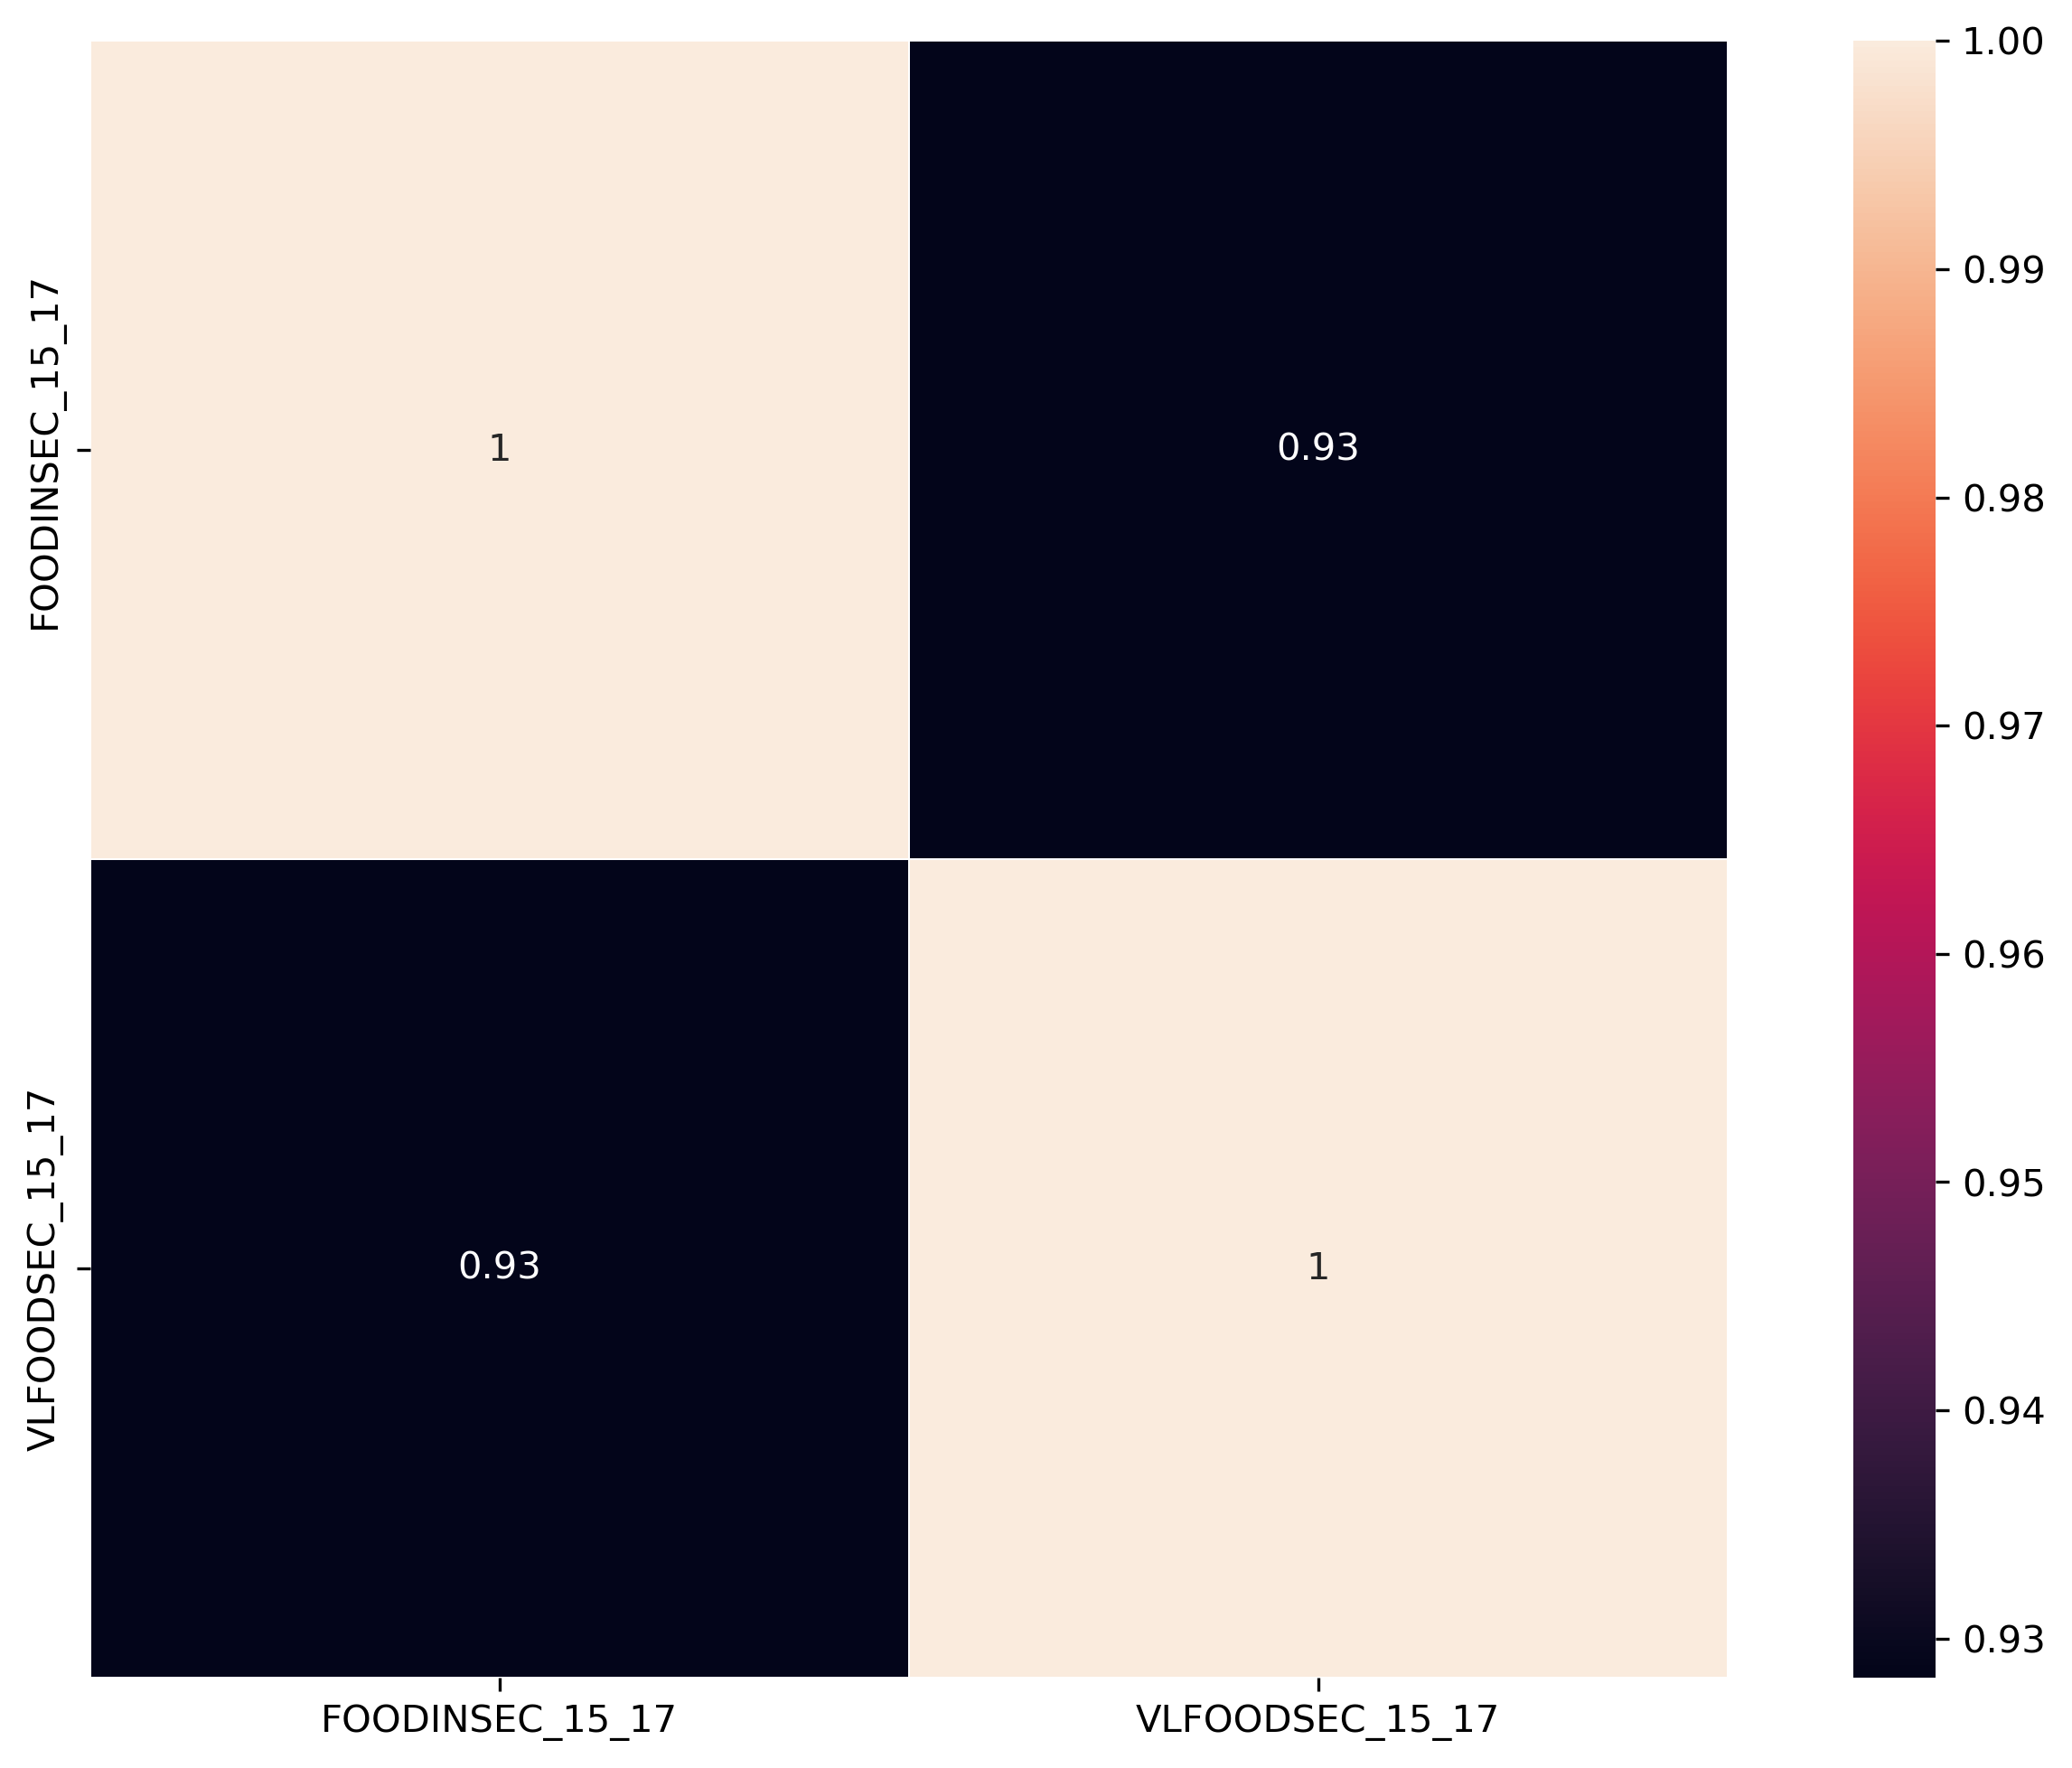

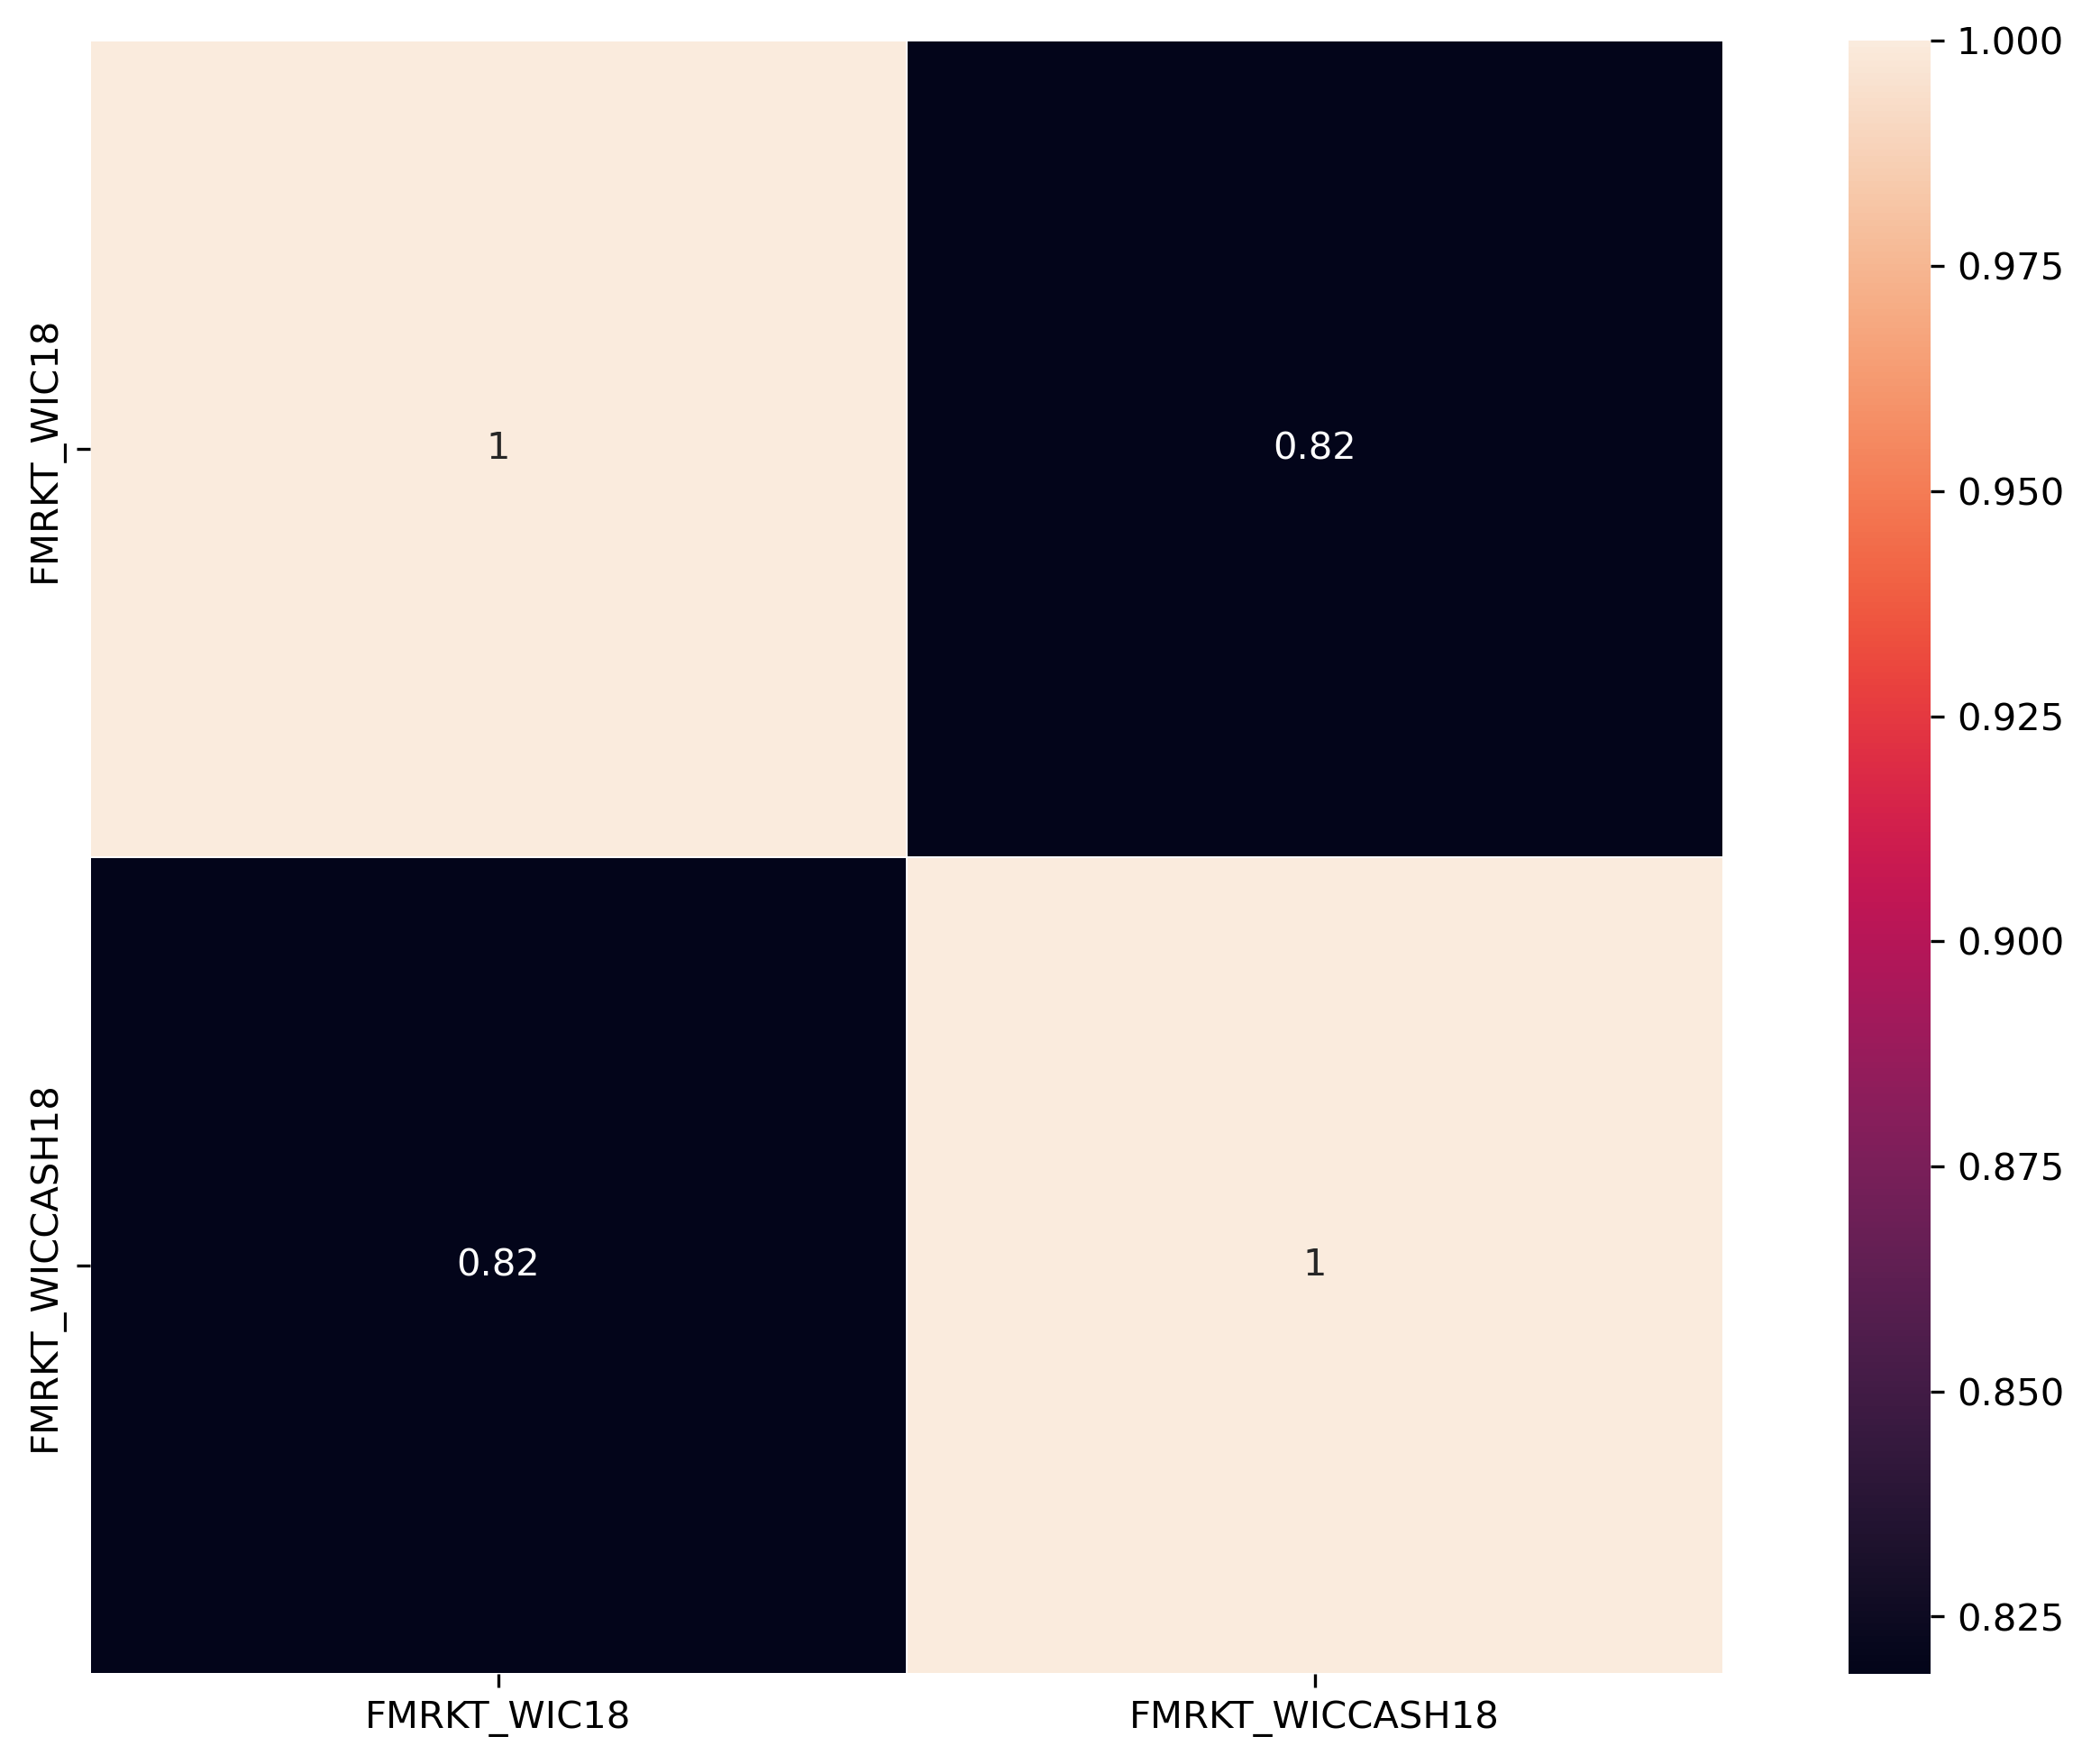

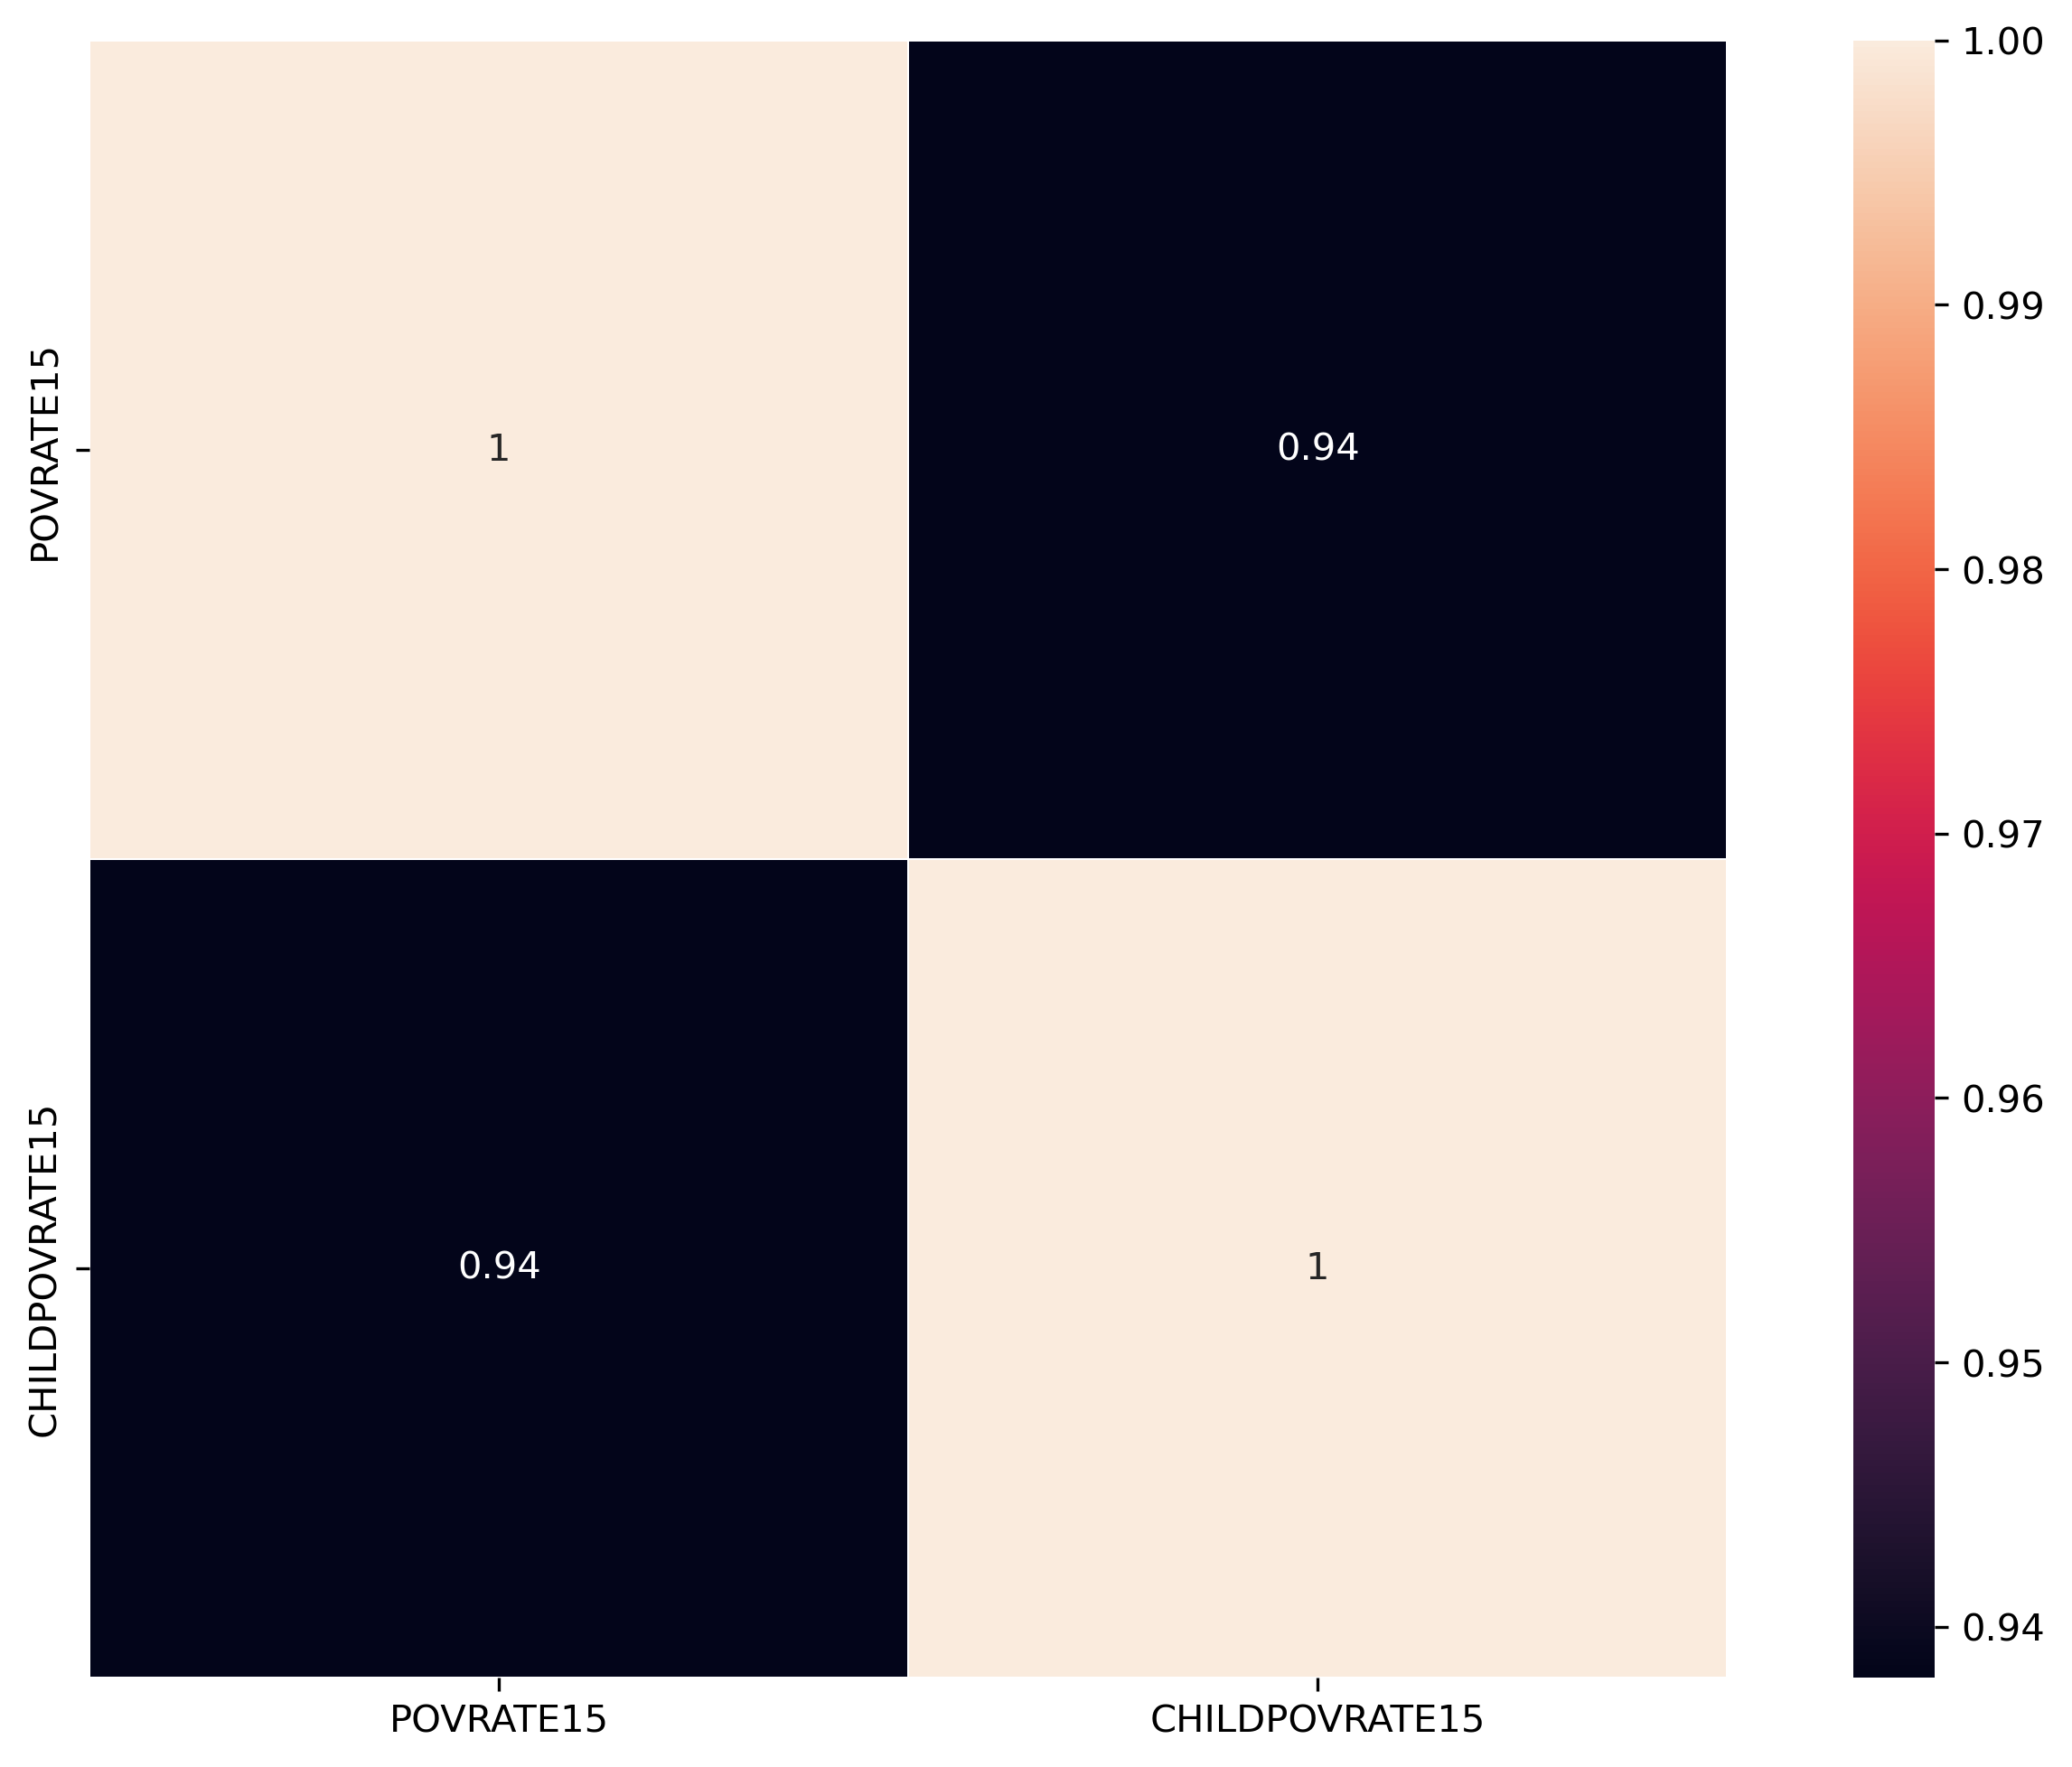

In [7]:
for i in range(len(group)):
    corr = raw_data[group[i]].corr()
    plt.figure(figsize = (12,8), dpi = 300)
#     sns.set(font_scale=2)
    sns.heatmap(corr,linewidths=0.1,vmax=1.0, square=True,linecolor='white', annot=True)
    plt.savefig('corr_heatmap_{}.jpg'.format(i))

## Data preprocessing

In [8]:
preserve_columns = ['State','LACCESS_POP15','GROCPTH16',
                    'SUPERCPTH16','CONVSPTH16','SPECSPTH16','WICSPTH16','FFRPTH16','FSRPTH16',
                    'FOODINSEC_15_17','FMRKT_WIC18','POVRATE15','PCT_WIC17']

raw_data['PCT_WIC17'] = raw_data['PCT_WIC17'] * raw_data['Population_Estimate_2016'] / 100
raw_data['FOODINSEC_15_17'] = raw_data['FOODINSEC_15_17'] * raw_data['Population_Estimate_2016'] / 100
raw_data['POVRATE15'] = raw_data['POVRATE15'] * raw_data['Population_Estimate_2016'] / 100

raw_data = raw_data[preserve_columns]


# for i in range(raw_data.shape[1]-2):
#     plt.figure(figsize = (12,8), dpi = 300)
#     plt.plot(range(raw_data.shape[0]), raw_data.iloc[:,i+2])
#     print(preserve_columns[i+2])



In [9]:
raw_data

,State,LACCESS_POP15,GROCPTH16,SUPERCPTH16,CONVSPTH16,SPECSPTH16,WICSPTH16,FFRPTH16,FSRPTH16,FOODINSEC_15_17,FMRKT_WIC18,POVRATE15,PCT_WIC17
0,Alabama,17496.693040,0.054271,0.018090,0.560802,0.018090,0.090511,0.795977,0.560802,9004.446,0.0,7015.734,1405.118725
1,Alabama,30561.264430,0.139753,0.033733,0.568650,0.130115,0.134802,0.751775,1.137300,33857.056,0.0,26794.848,5283.29931
2,Alabama,6069.523628,0.155195,0.038799,0.737177,0.077598,0.232387,0.892372,0.543183,4208.497,0.0,8262.08,656.724238
3,Alabama,969.378841,0.220916,0.044183,0.662749,0.000000,0.221474,0.309283,0.309283,3679.888,0.0,5011.872,574.236275
4,Alabama,3724.428242,0.086863,0.017373,0.469059,0.000000,0.139089,0.399569,0.208471,9375.271,1.0,8454.999,1462.984933
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,Wyoming,18934.737810,0.090406,0.022601,0.497231,0.022601,0.090344,0.700644,0.723246,5844.3,0.0,3763.375,776.384661
3137,Wyoming,6212.390430,0.474547,0.000000,0.819672,0.345125,0.129528,0.862813,2.545298,3057.252,0.0,1528.626,406.139924
3138,Wyoming,4686.017653,0.096567,0.048284,0.627686,0.096567,0.144991,0.820820,0.917387,2731.212,0.0,2027.718,362.827217
3139,Wyoming,931.411647,0.244260,0.000000,0.366390,0.000000,0.244858,0.732780,1.465559,1078.176,0.0,914.816,143.230038


In [10]:
temp = raw_data.iloc[:,1:]
normalization(temp)
raw_data.iloc[:,1:] = temp
enc = TargetEncoder(cols = ['State']).fit(raw_data['State'],raw_data['PCT_WIC17'])
raw_data['State'] = enc.transform(raw_data['State'])
data = raw_data.sample(frac = 1, random_state = random_state).values
X_train = np.float64(data[:2512,1:-1])
y_train = np.float64(data[:2512,-1])
X_test = np.float64(data[2512:,1:-1])
y_test = np.float64(data[2512:,-1])

D:\Program\anaconda\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
D:\Program\anaconda\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


## Baseline

In [11]:
models = []
for i in range(5):
    clf = LinearRegression()
    models.append(clf)
means_baseline, stds_baseline, index = cross_validate(models)
means_baseline

[0.8854847174860648,
 0.8854847174860648,
 0.8854847174860648,
 0.8854847174860648,
 0.8854847174860648]

In [12]:
dummy = DummyRegressor(strategy='mean').fit(X_train, y_train)
dummy_score = cross_val_score(dummy, X_train, y_train, cv = 5, scoring = 'r2')

print(dummy_score.mean(), dummy_score.std())
print(dummy_score)

-0.00045087367691518663 0.000454182810937786
[-1.19496254e-03 -2.29203076e-04 -5.20201043e-05 -2.72310376e-05
 -7.50951624e-04]


C:\Users\chenmo\AppData\Local\Temp\ipykernel_14380\2300599192.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\chenmo\AppData\Local\Temp\ipykernel_14380\2300599192.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Dummy:
MAE    Train:0.334799      Test:0.341275
MSE    Train:1.113798      Test:0.543961
RSQ    Train:0.000000      Test:-0.000173


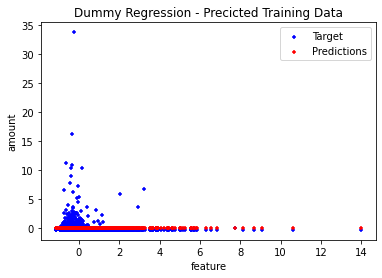

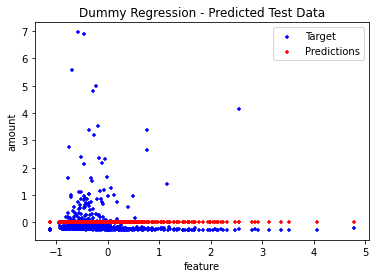

In [13]:
model_dummy = DummyRegressor(strategy='mean').fit(X_train, y_train)

plot_model_res(model_dummy, 'Dummy')

## Elastic Net

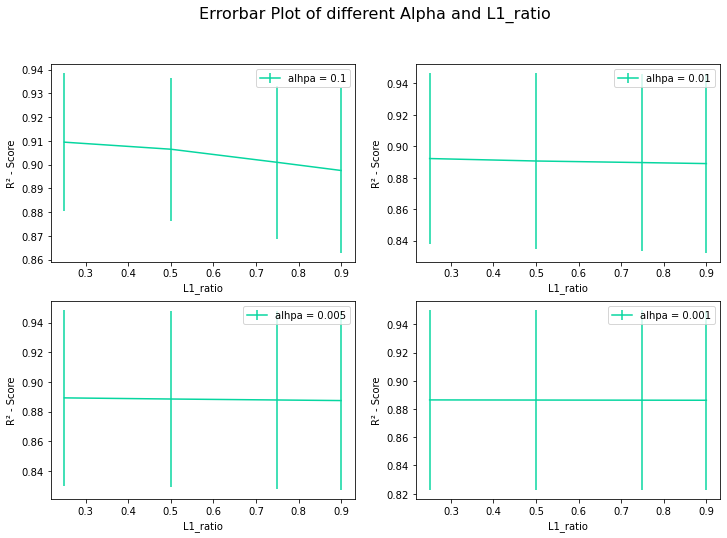

score 0.9094108606957914
alpha 0.1
ratio 0.25


In [14]:
alphas = [0.1, 0.01, 0.005, 0.001]
l1_ratio = [0.25, 0.5, 0.75, 0.9]

best_score = 0
best_alpha = 0
best_ratio = 0

fig = plt.figure(figsize=(12, 8))

for i, alpha in enumerate(alphas):
    mean_list = []
    std_list = []
    ElasticNet_clfs = []

    for radio in l1_ratio:
        model = ElasticNet(alpha=alpha, l1_ratio=radio, random_state=1212, max_iter=5000).fit(X_train, y_train)
        ElasticNet_clfs.append(model)

    mean_tmp, std_tmp, best_index = cross_validate(ElasticNet_clfs)
    
    if best_score < mean_tmp[best_index]:
        best_score = mean_tmp[best_index]
        best_ratio = l1_ratio[best_index]
        best_alpha = alpha
    
    ax = fig.add_subplot(2, 2, i + 1)
    plt.xlabel('L1_ratio')
    plt.ylabel('R² - Score')
    ax.errorbar(l1_ratio, mean_tmp, yerr=std_tmp, c='#06d6a0', label="alhpa = {}".format(alpha))
    plt.legend()


fig.suptitle("Errorbar Plot of different Alpha and L1_ratio", fontsize=16)
plt.show()

print('score', best_score)
print('alpha', best_alpha)
print('ratio', best_ratio)

Elastic Net:
MAE    Train:0.057108      Test:0.051167
MSE    Train:0.064118      Test:0.020554
RSQ    Train:0.942433      Test:0.962208


C:\Users\chenmo\AppData\Local\Temp\ipykernel_14380\2300599192.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\chenmo\AppData\Local\Temp\ipykernel_14380\2300599192.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


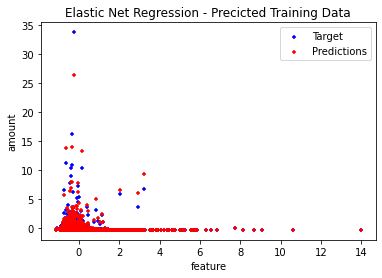

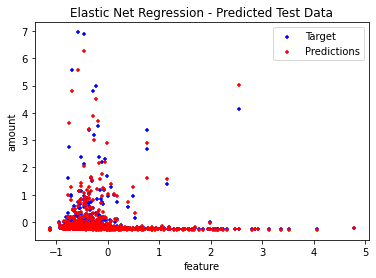

In [15]:
model_EN = ElasticNet(alpha=best_alpha, l1_ratio=best_ratio, random_state=random_state, max_iter=5000).fit(X_train, y_train)
plot_model_res(model_EN, 'Elastic Net')

## Decision tree

In [16]:
mean_dt = []
std_dt = []
DecisionTrees = []

depth_list = [3, 5, 7, 11, 13, 15]
best_score = 0
best_depth = 0


for depth in depth_list:
    clf = DecisionTreeRegressor(max_depth=depth, random_state = random_state)
    DecisionTrees.append(clf)

mean_dt, std_dt, index = cross_validate(DecisionTrees)

best_score = mean_dt[index]
best_depth = depth_list[index]

print(best_score, best_depth)

0.8084633045330951 5


In [17]:
mean_dt

[0.7674383598693211,
 0.8084633045330951,
 0.7827812924785132,
 0.7523728994610158,
 0.7490507440268661,
 0.7644176654131679]

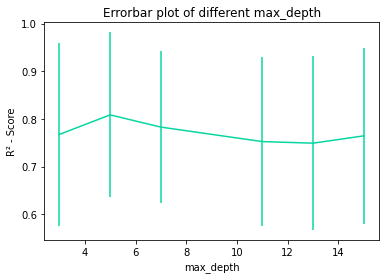

In [18]:
fig, axs = plt.subplots()
axs.errorbar(depth_list, mean_dt, yerr=std_dt, c='#06d6a0')
axs.set_title("Errorbar plot of different max_depth")
axs.set_xlabel('max_depth')
axs.set_ylabel('R² - Score')
plt.show()

dt:
MAE    Train:0.041245      Test:0.069626
MSE    Train:0.009713      Test:0.064194
RSQ    Train:0.991280      Test:0.881968


C:\Users\chenmo\AppData\Local\Temp\ipykernel_14380\2300599192.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\chenmo\AppData\Local\Temp\ipykernel_14380\2300599192.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


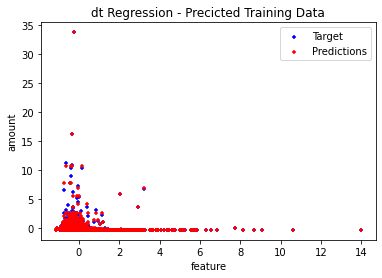

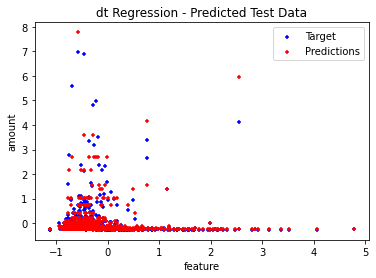

In [19]:
model_dt = DecisionTreeRegressor(max_depth=best_depth, random_state = random_state).fit(X_train, y_train)
plot_model_res(model_dt, 'dt')

## MLP

In [20]:
NNs = []
size_list = [(64,8),(64,16,4),(128,16),(128,32,8)]
alpha_list = [0.1, 0.01, 0.001, 0.0001]

best_score = 0
best_size = ()
best_alpha = 0

for i in range(len(size_list)):
    NN_same_size = []
    for alpha in alpha_list:
        clf = MLPRegressor(hidden_layer_sizes = size_list[i],
                           learning_rate_init = alpha,
                           random_state = random_state, max_iter = 2000)
        NN_same_size.append(clf)
    NNs.append(NN_same_size)

In [21]:
%%time
NN_means = []
NN_stds = []
for i in range(len(NNs)):
    NN_mean, NN_std, index = cross_validate(NNs[i])
    NN_means.append(NN_mean)
    NN_std.append(NN_std)

    curr_score = NN_mean[index]
    if curr_score > best_score:
        best_score = curr_score
        best_size = size_list[index]
        best_alpha = alpha_list[index]
        
print(best_score, best_size, best_alpha)

0.9184484762203574 (128, 16) 0.001
CPU times: total: 39.6 s
Wall time: 1min 13s


mlp:
MAE    Train:0.039915      Test:0.057970
MSE    Train:0.011539      Test:0.018963
RSQ    Train:0.989640      Test:0.965133


C:\Users\chenmo\AppData\Local\Temp\ipykernel_14380\2300599192.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\chenmo\AppData\Local\Temp\ipykernel_14380\2300599192.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


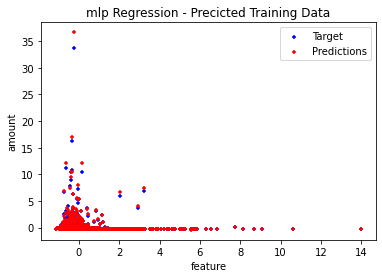

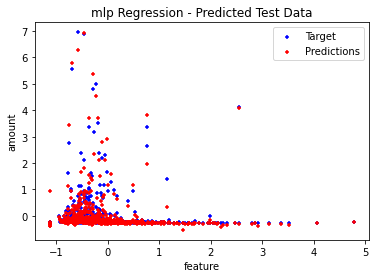

In [22]:
model_mlp = MLPRegressor(hidden_layer_sizes = best_size,
                           learning_rate_init = best_alpha,
                           random_state = random_state, max_iter = 2000).fit(X_train, y_train)

plot_model_res(model_mlp, 'mlp')

In [23]:
for i in range(3):
    print(10 ** (-i - 2),)

0.01
0.001
0.0001
